# **MedSRGAN training**

## Загрузка инструментария

In [1]:
import os
import random
import numpy as np
from tqdm import tqdm

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision.transforms import Compose, RandomCrop, ToTensor, ToPILImage, Resize, Grayscale
from torchmetrics.image import StructuralSimilarityIndexMeasure, PeakSignalNoiseRatio

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

## Загрузка данных


In [2]:
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [
        '.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG'
    ])


def calculate_valid_crop_size(crop_size, upscale_factor):
    return crop_size - (crop_size % upscale_factor)


def train_hr_transform(crop_size):
    return Compose([
        Resize(1024),
        Grayscale(),
        RandomCrop(crop_size),
        ToTensor(),
    ])


def train_lr_transform(crop_size, upscale_factor):
    return Compose([
        ToPILImage(),
        Grayscale(),
        Resize(crop_size // upscale_factor, interpolation=Image.BICUBIC),
        ToTensor()
    ])

    
class TrainDatasetFromFolder(Dataset):
    def __init__(self, image_filenames, crop_size, upscale_factor):
        super(TrainDatasetFromFolder, self).__init__()
        self.image_filenames = image_filenames
        crop_size = calculate_valid_crop_size(crop_size, upscale_factor)
        self.hr_transform = train_hr_transform(crop_size)
        self.lr_transform = train_lr_transform(crop_size, upscale_factor)

    def __getitem__(self, index):
        hr_image = self.hr_transform(Image.open(self.image_filenames[index]))
        lr_image = self.lr_transform(hr_image)
        return lr_image, hr_image

    def __len__(self):
        return len(self.image_filenames)

In [3]:
# Путь до директории с данными
input_dir = '/kaggle/input'

# Функция для получения всех поддиректорий в указанной директории
def get_dirs_paths(root_dir):
    dirs = []
    for subdir, _, _ in os.walk(root_dir):
        dirs.append(subdir)
    return dirs

# Получаем все поддиректории в /kaggle/input
dirs_paths = get_dirs_paths(input_dir)

# Вывод всех путей
# for path in dirs_paths:
#     print(path)

In [4]:
# Собираем пути к изображениям в едином списке
dirs_paths = [
    '/kaggle/input/covid19-pneumonia-normal-chest-xray-pa-dataset/covid',
    '/kaggle/input/covid19-pneumonia-normal-chest-xray-pa-dataset/normal',
    '/kaggle/input/covid19-pneumonia-normal-chest-xray-pa-dataset/pneumonia',
    '/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA',
    '/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL',
    '/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA',
    '/kaggle/input/chest-xray-pneumonia/chest_xray/val/NORMAL',
    '/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA',
    '/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL'
]
imgs_paths = []
for dir_path in dirs_paths:
    imgs_paths.extend(
        [os.path.join(dir_path, x) for x in os.listdir(dir_path) if is_image_file(x)]
    )
    
# Перемешиваем список
random.shuffle(imgs_paths)

# Вычисляем индекс разделения на выборок с 15% на валидацию
train_size = int(len(imgs_paths) * 0.85)

# Разделяем список на две выборки
train_paths = imgs_paths[:train_size]
val_paths = imgs_paths[train_size:]

UPSCALE_FACTOR = 4
CROP_SIZE = 256
BATCH_SIZE = 16

train_data = TrainDatasetFromFolder(
    train_paths, crop_size=CROP_SIZE,
    upscale_factor=UPSCALE_FACTOR
    )

valid_data = TrainDatasetFromFolder(
    val_paths, crop_size=CROP_SIZE,
    upscale_factor=UPSCALE_FACTOR
    )

trainloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    num_workers=os.cpu_count(),
    shuffle=True,
    pin_memory=True
)

valloader = DataLoader(
    dataset=valid_data,
    batch_size=BATCH_SIZE,
    num_workers=os.cpu_count(),
    shuffle=False,
    pin_memory=True
)

print('Len of train dataset:', len(train_data))
print('Len of valid dataset:', len(valid_data))
print('Num of packages in the train loader:', len(trainloader))
print('Num of packages in the valid loader:', len(valloader))

Len of train dataset: 10844
Len of valid dataset: 1914
Num of packages in the train loader: 678
Num of packages in the valid loader: 120


In [5]:
# Функция для визуализации двух случайных изображений
def visualize_random_images(dataset):
    # Получаем случайные индексы
    indices = random.sample(range(len(dataset)), 3)
    
    # Получаем изображения по индексам
    images = [dataset[i] for i in indices]
    
    # Настройка графика
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 12))
    
    for i, (lr_image, hr_image) in enumerate(images):
        # Преобразуем тензоры в numpy массивы для визуализации
        lr_image = lr_image.permute(1, 2, 0).numpy()  # (height, width, channels)
        hr_image = hr_image.permute(1, 2, 0).numpy()
        
        # Визуализация LR изображения
        axes[i, 0].imshow(lr_image, cmap='gray')
        axes[i, 0].axis('off')
        axes[i, 0].set_title('LR Image {}'.format(indices[i]))

        # Визуализация HR изображения
        axes[i, 1].imshow(hr_image, cmap='gray')
        axes[i, 1].axis('off')
        axes[i, 1].set_title('HR Image {}'.format(indices[i]))

    plt.tight_layout()
    plt.show()

# Вызов функции визуализации
visualize_random_images(train_data)

## Модель

Попробуем восстановить архитектуру сетей нашего GAN-a по схемам из статьи.

In [6]:
class RWMAB(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.part1 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, (3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels, in_channels, (3, 3), stride=1, padding=1)
        )
        self.part2 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, (1, 1), stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x):
        x1 = self.part1(x)
        x2 = self.part2(x)

        return x2*x1+x
    

class ShortResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        
        self.layers = nn.ModuleList([RWMAB(in_channels) for _ in range(16)])
        
    def forward(self, x):
        x1 = x.clone()
        
        for layer in self.layers:
            x1 = layer(x1)
        
        return x + x1
    
    
class Generator(nn.Module):
    def __init__(self, in_channels=1, blocks=8):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, 64, (3, 3), stride=1, padding=1)
        
        self.short_blocks = nn.ModuleList(
            [ShortResidualBlock(64) for _ in range(blocks)]
        )

        self.conv2 = nn.Conv2d(64, 64, (1, 1), stride=1, padding=0)

        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, (3, 3), stride=1, padding=1),
            nn.PixelShuffle(2),
            nn.Conv2d(64, 256, (3, 3), stride=1, padding=1),
            nn.PixelShuffle(2), 
            nn.Conv2d(64, 1, (1, 1), stride=1, padding=0),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        x = self.conv(x)
        x1 = x.clone()

        for layer in self.short_blocks:
            x1 = layer(x1)
        x = torch.cat([self.conv2(x1), x], dim=1)
        x = self.conv3(x)
        
        return x

Теперь дискриминатор:

In [7]:
class D_Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2):
        super().__init__()

        self.layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, (3, 3), stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(negative_slope=0.2),
        )

    def forward(self, x):

        return self.layer(x)


class Discriminator(nn.Module):
    def __init__(self, img_size, in_channels=1):
        super().__init__()

        self.conv_1_1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, (3, 3), stride=1, padding=1),
            nn.LeakyReLU(negative_slope=0.2)
        )

        self.block_1_1 = D_Block(64, 64, stride=1)
        self.block_1_2 = D_Block(64, 128, stride=1)
        self.block_1_3 = D_Block(128, 128, stride=1)

        self.conv_2_1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, (3, 3), stride=2, padding=1),
            nn.LeakyReLU(negative_slope=0.2)
        )

        self.block_2_2 = D_Block(64, 128)

        self.block3 = D_Block(256, 256, stride=1)
        self.block4 = D_Block(256, 256)
        self.block5 = D_Block(256, 512, stride=1)
        self.block6 = D_Block(512, 512)
        self.block7 = D_Block(512, 1024, stride=1)
        self.block8 = D_Block(1024, 1024)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(1024 * img_size[0] * (img_size[1] // 4) // 16, 100)
        self.fc2 = nn.Linear(100, 1)
        self.relu = nn.LeakyReLU(negative_slope=0.2)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x1, x2):
        x_1 = self.block_1_3(self.block_1_2(self.block_1_1(self.conv_1_1(x1))))
        x_2 = self.block_2_2(self.conv_2_1(x2))
        x = torch.cat([x_1, x_2], dim=1)
        x = self.block8(self.block7(self.block6(self.block5(self.block4(self.block3(x))))))
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(self.relu(x))

        return self.sigmoid(x)

    def get_features(self, x1, x2):
        features = []
        x_1 = self.block_1_1(self.conv_1_1(x1))
        features.append(x_1)
        x_1 = self.block_1_3(self.block_1_2(x_1))
        features.append(x_1)
        x_2 = self.block_2_2(self.conv_2_1(x2))
        x = torch.cat([x_1, x_2], dim=1)
        x = self.block4(self.block3(x))
        features.append(x)
        x = self.block6(self.block5(x))
        features.append(x)
        x = self.block8(self.block7(x))
        features.append(x)

        return features

## Обучение

Сперва распишем функции для расчёта компонентов loss-функции генератора. 

In [8]:
# Content loss
class ContentLoss(nn.Module):
    def __init__(self, lambdaL1=1):
        super(ContentLoss, self).__init__()
        self.lambdaL1 = lambdaL1
        vgg19 = torchvision.models.vgg19(weights='IMAGENET1K_V1')
        vgg19.features[0] = nn.Conv2d(
            1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
        )
        self.vgg = vgg19
        for param in self.vgg.parameters():
            param.requires_grad = False
        
        # Выбираем слои для извлечения признаков
        self.selected_layers = [2, 7, 16, 25, 34]
        self.weights = [1/2, 1/4, 1/8, 1/16, 1/16]
        self.l1_loss = nn.L1Loss()
        self.mse_loss = nn.MSELoss()

    def forward(self, sr, hr):
        sr_features = self.extract_features(sr)
        hr_features = self.extract_features(hr)

        content_loss = self.lambdaL1 * self.l1_loss(sr, hr)
        for i in range(5):
            content_loss += self.weights[i] * self.mse_loss(
                sr_features[i], hr_features[i]
            )

        return content_loss

    def extract_features(self, x):
        features = []
        for i in range(len(self.vgg.features)):
            x = self.vgg.features[i](x)
            if i in self.selected_layers:
                features.append(x)
        return features

# Adversarial loss
class AdvLoss(nn.Module):
    def __init__(self):
        super(AdvLoss, self).__init__()
        self.bce_loss = nn.BCELoss()

    def forward(self, d_sr, d_hr):
        real_label = torch.ones_like(d_sr)
        fake_label = torch.zeros_like(d_hr)
        return self.bce_loss(d_sr, real_label) + self.bce_loss(d_hr, fake_label)

# Adversarial feature loss
class AdvFeatureLoss(nn.Module):
    def __init__(self, discriminator):
        super(AdvFeatureLoss, self).__init__()
        self.discriminator = discriminator
        self.mse_loss = nn.MSELoss()

    def forward(self, lr, sr, hr):
        weights = [1/2, 1/4, 1/8, 1/16, 1/16]
        d_hr_features = self.discriminator.get_features(lr, hr)
        d_sr_features = self.discriminator.get_features(lr, sr)
        
        adv_feature_loss = 0
        for i in range(len(d_hr_features)):
            adv_feature_loss += weights[i] * self.mse_loss(d_hr_features[i], d_sr_features[i])
        
        return adv_feature_loss

Функции для обучения дискриминатора и генератора:

In [9]:
def train_discriminator(discriminator, generator, lr_images, hr_images, optimizer_D, phase='train'):
    # Установим градиенты в ноль
    optimizer_D.zero_grad()

    # Создадим фейковые изображения высокого разрешения
    with torch.no_grad():
        fake_hr_images = generator(lr_images)

    # Оценка реальных изображений
    real_outputs = discriminator(lr_images, hr_images)
    
    # Оценка фейковых изображений
    fake_outputs = discriminator(lr_images, fake_hr_images.detach())

    # Вычисление потерь
    loss_real = -torch.log(real_outputs).mean()
    loss_fake = -torch.log(1 - fake_outputs).mean()

    # Общая потеря дискриминатора
    loss_D = loss_real + loss_fake
    
    if phase == 'train':
        # Обратное распространение ошибки и оптимизация
        loss_D.backward()
        optimizer_D.step()

    return loss_D.item()


def train_generator(generator, discriminator, content_loss, adv_loss, adv_feature_loss, 
                    lr_images, hr_images, optimizer_G, lambda1, lambda2, phase='train'):
    optimizer_G.zero_grad()

    # Генерация SR изображений
    sr_images = generator(lr_images)

    # Вычисление content loss
    c_loss = content_loss(sr_images, hr_images)

    # Вычисление adversarial loss
    d_sr = discriminator(lr_images, sr_images)
    d_hr = discriminator(lr_images, hr_images)
    a_loss = adv_loss(d_sr, d_hr)

    # Вычисление adversarial feature loss
    af_loss = adv_feature_loss(lr_images, sr_images, hr_images)

    # Общая потеря генератора
    g_loss = c_loss + lambda1 * a_loss + lambda2 * af_loss
    
    if phase == 'train':
        # Обратное распространение ошибки и оптимизация
        g_loss.backward()
        optimizer_G.step()

    return g_loss.item(), c_loss.item(), a_loss.item(), af_loss.item()

И непосредственно скрипт трейнера:

In [10]:
def trainer(Gen, Disc, trainloader, valloader,
            N_EPOCHS=150, N_ROUNDS=4, lambda1=0.1, lambda2=0.1):
    BEST_PSNR, BEST_SSIM, BEST_LOSS = -np.inf, -np.inf, np.inf
    K = 0
    results = {
        "d_train_loss":[], "d_valid_loss":[],
        "g_train_loss":[], "g_valid_loss":[],
        "c_train_loss":[], "c_valid_loss":[],
        "a_train_loss":[], "a_valid_loss":[],
        "af_train_loss":[], "af_valid_loss":[],
        "train_psnr": [], "valid_psnr":[],
        "train_ssim": [], "valid_ssim":[]
    }

    for epoch in range(1, N_EPOCHS + 1):
        is_early_stopping = False
        train_bar = tqdm(trainloader)
        running_results = {
            'd_loss': 0, 'g_loss': 0,
            'c_loss': 0, 'a_loss': 0, 'af_loss': 0,
            'psnr': 0, 'ssim': 0
        }

        metrics = [PeakSignalNoiseRatio(), StructuralSimilarityIndexMeasure()]

        Gen.train()
        Disc.train()

        # Тренировочная часть
        for data in train_bar:
            lr_img, hr_img = data
            lr_img, hr_img = lr_img.to(device), hr_img.to(device)
            with torch.no_grad():
                pred_hr = Gen(lr_img)

            # Обучение дискриминатора
            d_loss = train_discriminator(Disc, Gen, lr_img, hr_img, optimizer_D)
            scheduler_D.step()

            # Обучение генератора
            g_loss, c_loss, a_loss, af_loss = train_generator(
                Gen, Disc, content_loss, adv_loss, adv_feature_loss, 
                lr_img, hr_img, optimizer_G, lambda1, lambda2 # lambda1 * a_loss, lambda2 * af_loss
                )
            scheduler_G.step()

            running_results['d_loss'] += d_loss
            running_results['g_loss'] += g_loss
            running_results['c_loss'] += c_loss
            running_results['a_loss'] += a_loss
            running_results['af_loss'] += af_loss

            psnr = metrics[0](hr_img.detach().cpu() * 255, pred_hr.detach().cpu() * 255).item()
            ssim = metrics[1](hr_img.detach().cpu() * 255, pred_hr.detach().cpu() * 255).item()
            running_results['psnr'] += psnr
            running_results['ssim'] += ssim
            
            train_bar.set_description(
                desc="T[%d/%d] Loss_D: %.4f | Loss_G: %.4f | Loss_C: %.4f | Loss_A: %.4f | Loss_AF: %.4f | PSNR: %.4f | SSIM: %.4f" % (
                    epoch, N_EPOCHS, d_loss, g_loss, c_loss, a_loss, af_loss, psnr, ssim
                )
            )
            
        # Сохраняем результаты тренировки
        results['d_train_loss'].append(running_results['d_loss'] / len(trainloader))
        results['g_train_loss'].append(running_results['g_loss'] / len(trainloader))
        results['c_train_loss'].append(running_results['c_loss'] / len(trainloader))
        results['a_train_loss'].append(running_results['a_loss'] / len(trainloader))
        results['af_train_loss'].append(running_results['af_loss'] / len(trainloader))
        results['train_psnr'].append(running_results['psnr'] / len(trainloader))
        results['train_ssim'].append(running_results['ssim'] / len(trainloader))

        # Валидационная часть
        val_bar = tqdm(valloader)
        netG.eval()
        netD.eval()
        val_running_results = {
            'val_d_loss': 0, 'val_g_loss': 0,
            'val_c_loss': 0, 'val_a_loss': 0, 'val_af_loss': 0,
            'val_psnr': 0, 'val_ssim': 0
        }

        with torch.no_grad():
            for data in val_bar:
                lr_img, hr_img = data
                lr_img, hr_img = lr_img.to(device), hr_img.to(device)
                pred_hr = Gen(lr_img)

                # Обучение дискриминатора
                d_loss = train_discriminator(
                    Disc, Gen, lr_img, hr_img, optimizer_D, phase='valid'
                )

                # Обучение генератора
                g_loss, c_loss, a_loss, af_loss = train_generator(
                    Gen, Disc, content_loss, adv_loss, adv_feature_loss, 
                    lr_img, hr_img, optimizer_G, 0.1, 0.1, # lambda1, lambda2
                    phase='valid'
                    )

                val_running_results['val_d_loss'] += d_loss
                val_running_results['val_g_loss'] += g_loss
                val_running_results['val_c_loss'] += c_loss
                val_running_results['val_a_loss'] += a_loss
                val_running_results['val_af_loss'] += af_loss

                # Метрики для валидационной части
                psnr = metrics[0](hr_img.detach().cpu() * 255, pred_hr.detach().cpu() * 255).item()
                ssim = metrics[1](hr_img.detach().cpu() * 255, pred_hr.detach().cpu() * 255).item()

                val_running_results['val_psnr'] += psnr
                val_running_results['val_ssim'] += ssim
            
                val_bar.set_description(
                    desc="V[%d/%d] Loss_D: %.4f | Loss_G: %.4f | Loss_C: %.4f | Loss_A: %.4f | Loss_AF: %.4f | PSNR: %.4f | SSIM: %.4f | [K: %d]"% (
                        epoch, N_EPOCHS, d_loss, g_loss, c_loss, a_loss, af_loss, psnr, ssim, K
                    )
                )

        # Сохраняем результаты валидации
        results['d_valid_loss'].append(val_running_results['val_d_loss'] / len(valloader))
        results['g_valid_loss'].append(val_running_results['val_g_loss'] / len(valloader))
        results['c_valid_loss'].append(val_running_results['val_c_loss'] / len(valloader))
        results['a_valid_loss'].append(val_running_results['val_a_loss'] / len(valloader))
        results['af_valid_loss'].append(val_running_results['val_af_loss'] / len(valloader))
        results['valid_psnr'].append(val_running_results['val_psnr'] / len(valloader))
        results['valid_ssim'].append(val_running_results['val_ssim'] / len(valloader))
        
        # Логика ранней остановки и сохранения модели
        if (results['valid_psnr'][-1] > BEST_PSNR) & (results['valid_ssim'][-1] > BEST_SSIM):
            torch.save(Gen.state_dict(), "best_G.pt")
            BEST_PSNR = results['valid_psnr'][-1]
            BEST_SSIM = results['valid_ssim'][-1]

        if BEST_LOSS > round(results['g_valid_loss'][-1], 6):
            BEST_LOSS = round(results['g_valid_loss'][-1], 6)
            K = 0
        elif K == N_ROUNDS:
            is_early_stopping = True
        else:
            K += 1
        
        torch.save(Gen.state_dict(), "last_G.pt")
        
        if is_early_stopping:
            print(f"Early stopping at epoch {epoch}")
            break
        
    # Загрузим лучшие веса в модель
    Gen.load_state_dict(torch.load("best_G.pt", weights_only=True))
        
    return results, Gen

In [11]:
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")

netG = Generator(in_channels=1, blocks=2)
netD = Discriminator(
    [int(CROP_SIZE/UPSCALE_FACTOR), 
     int(CROP_SIZE/UPSCALE_FACTOR)],
     in_channels=1
)

Gen = netG.to(device)
Disc = netD.to(device)

optimizer_G = optim.Adam(Gen.parameters(), lr=1e-3, weight_decay=1e-5)
optimizer_D = optim.Adam(Disc.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler_G = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer_G, T_0=8, T_mult=2, eta_min=1e-5
)
scheduler_D = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer_D, T_0=4, T_mult=1, eta_min=1e-4
)
content_loss = ContentLoss(lambdaL1=0).to(device)
adv_loss = AdvLoss().to(device)
adv_feature_loss = AdvFeatureLoss(Disc).to(device)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 187MB/s]  


In [12]:
results, Gen = trainer(
    Gen, Disc, trainloader, valloader,
    N_EPOCHS=150, N_ROUNDS=4,
    lambda1=1e-2, lambda2=1e-4
)

T[1/150] Loss_D: 1.3989 | Loss_G: 0.0143 | Loss_C: 0.0003 | Loss_A: 1.3953 | Loss_AF: 0.0010 | PSNR: 29.4583 | SSIM: 0.6286: 100%|██████████| 678/678 [14:23<00:00,  1.27s/it] 
V[1/150] Loss_D: 1.4001 | Loss_G: 0.1387 | Loss_C: 0.0003 | Loss_A: 1.3766 | Loss_AF: 0.0072 | PSNR: 29.6924 | SSIM: 0.6340 | [K: 0]: 100%|██████████| 120/120 [01:33<00:00,  1.29it/s]
T[2/150] Loss_D: 1.3848 | Loss_G: 0.0141 | Loss_C: 0.0002 | Loss_A: 1.3891 | Loss_AF: 0.0003 | PSNR: 33.2271 | SSIM: 0.8249: 100%|██████████| 678/678 [14:26<00:00,  1.28s/it]
V[2/150] Loss_D: 1.3950 | Loss_G: 0.1383 | Loss_C: 0.0001 | Loss_A: 1.3815 | Loss_AF: 0.0005 | PSNR: 34.5101 | SSIM: 0.8384 | [K: 0]: 100%|██████████| 120/120 [01:32<00:00,  1.30it/s]
T[3/150] Loss_D: 1.4310 | Loss_G: 0.0148 | Loss_C: 0.0004 | Loss_A: 1.4363 | Loss_AF: 0.0007 | PSNR: 29.9111 | SSIM: 0.8190: 100%|██████████| 678/678 [14:26<00:00,  1.28s/it]
V[3/150] Loss_D: 1.4334 | Loss_G: 0.1457 | Loss_C: 0.0004 | Loss_A: 1.4500 | Loss_AF: 0.0028 | PSNR: 29.60

Early stopping at epoch 11


## Визуализация динамики обучения

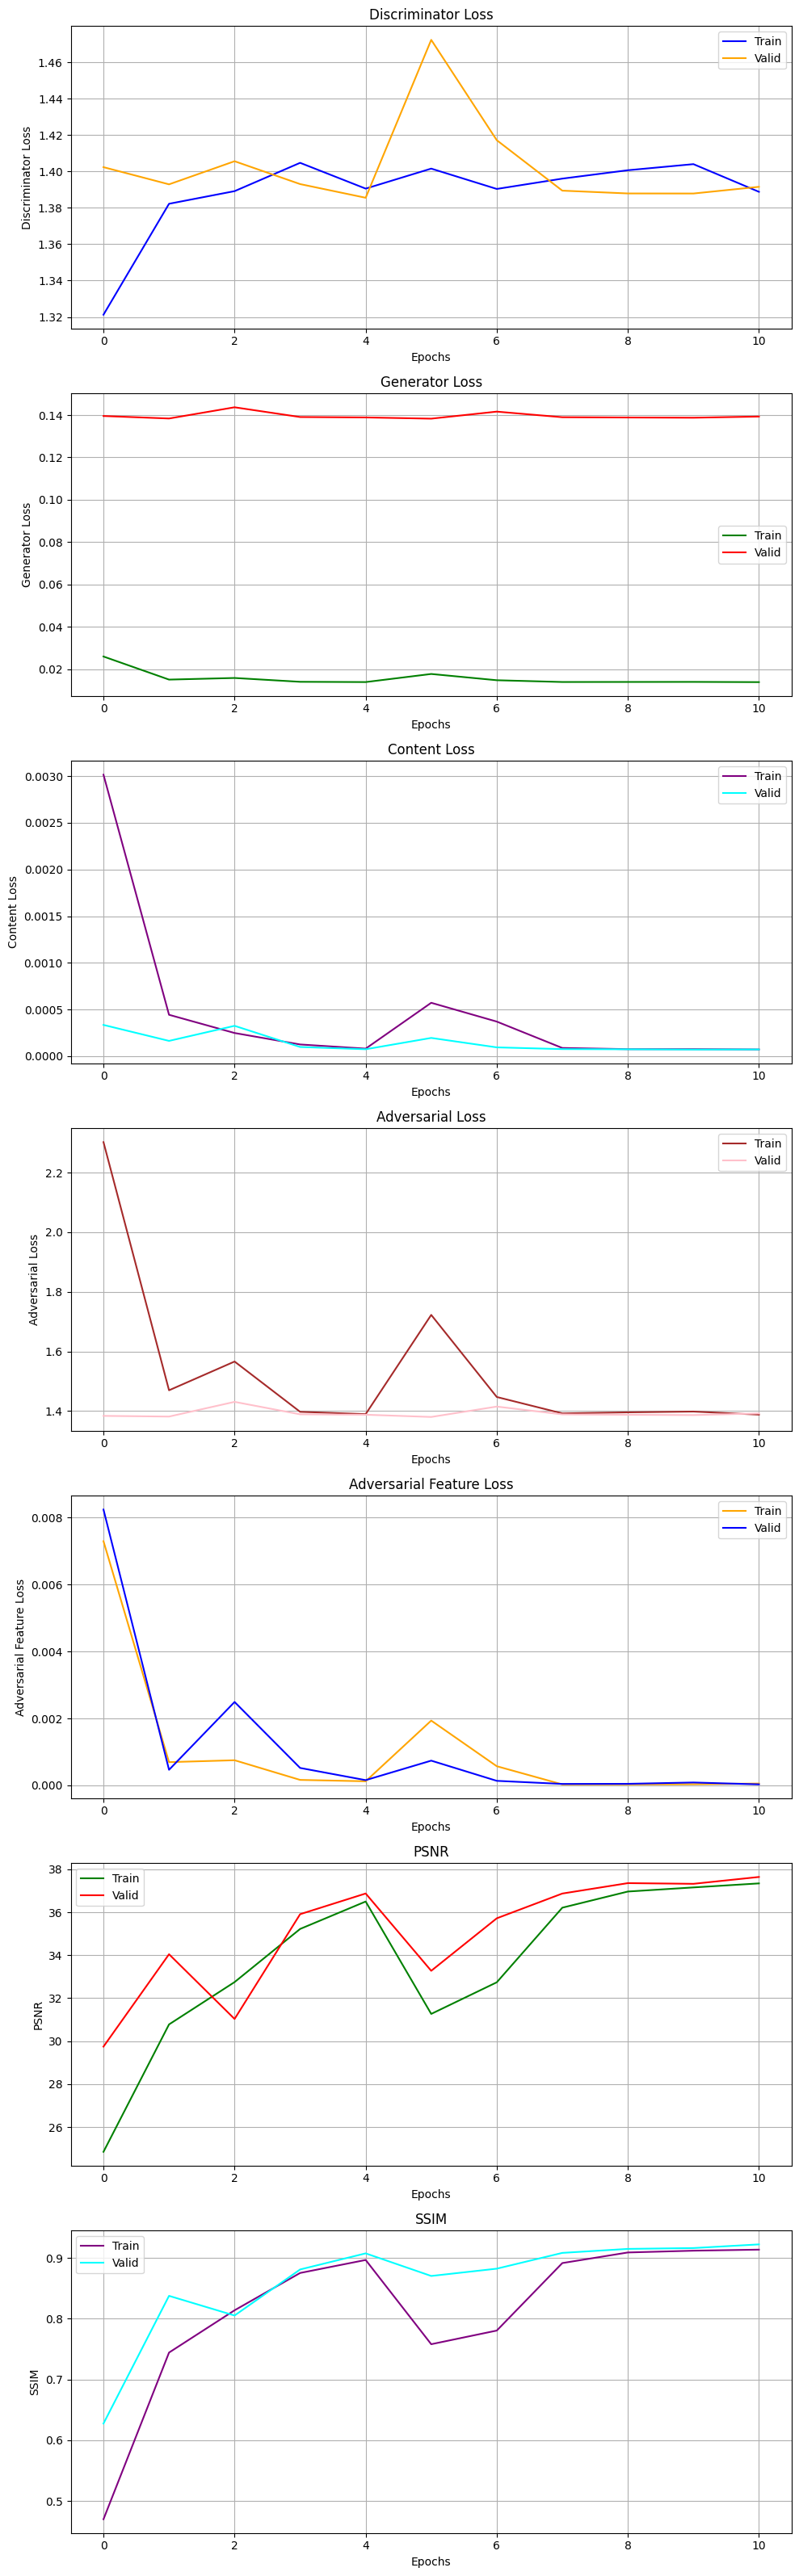

In [13]:
# Функция для визуализации данных
def plot_results(results):
    # Создаем фигуру с подграфиками
    fig, axs = plt.subplots(7, 1, figsize=(10, 32))
    
    # Параметры для графиков
    metrics = [
        ("d_train_loss", "d_valid_loss", "Discriminator Loss", 'blue', 'orange'),
        ("g_train_loss", "g_valid_loss", "Generator Loss", 'green', 'red'),
        ("c_train_loss", "c_valid_loss", "Content Loss", 'purple', 'cyan'),
        ("a_train_loss", "a_valid_loss", "Adversarial Loss", 'brown', 'pink'),
        ("af_train_loss", "af_valid_loss", "Adversarial Feature Loss", 'orange', 'blue'),
        ("train_psnr", "valid_psnr", "PSNR", 'green', 'red'),
        ("train_ssim", "valid_ssim", "SSIM", 'purple', 'cyan')
    ]
    
    # Проходим по метрикам и строим графики
    for i, (train_metric, valid_metric, title, colorT, colorV) in enumerate(metrics):
        ax = axs[i]
        ax.plot(results[train_metric], label='Train', color=colorT)
        ax.plot(results[valid_metric], label='Valid', color=colorV)
        ax.set_title(title)
        ax.set_xlabel('Epochs')
        ax.set_ylabel(title)
        ax.legend()
        ax.grid()
    
    plt.tight_layout()
    plt.show()
    
# Вызовем функцию на наших результатах
plot_results(results)

## Тест

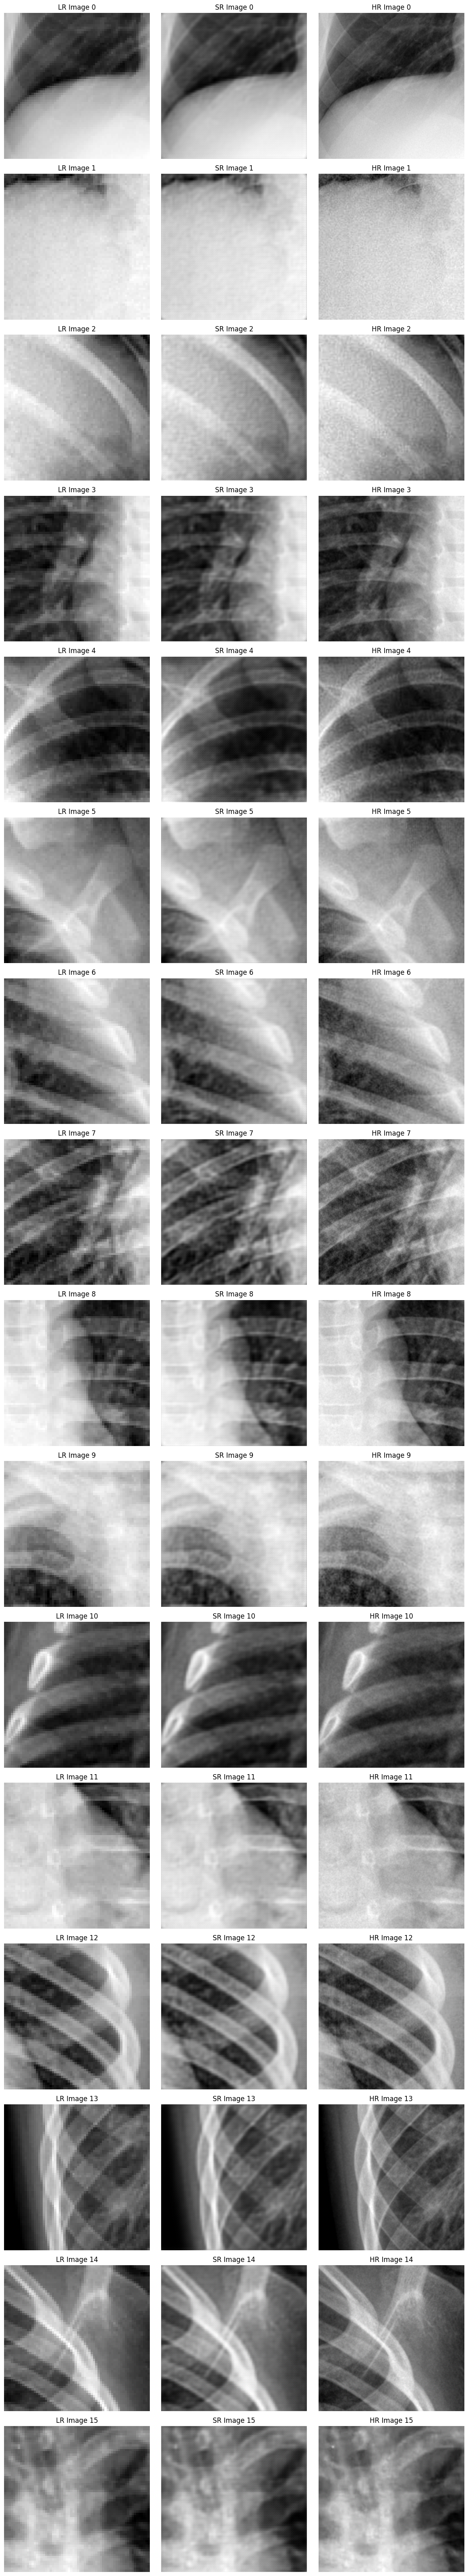

In [16]:
# Функция для визуализации батча изображений
def visualize_batch_images(generator, valloader):
    # Переводим генератор в режим eval
    generator.eval()

    # Получаем один батч из загрузчика данных
    lr_images, hr_images = next(iter(valloader))

    with torch.no_grad():  # Отключаем градиенты для экономии памяти
        # Генерация суперразрешенных изображений
        sr_images_tensor = generator(lr_images.to(device))

    # Настройка графика
    fig, axes = plt.subplots(nrows=BATCH_SIZE, ncols=3, figsize=(12, 4 * BATCH_SIZE))

    for i in range(BATCH_SIZE):
        # Преобразуем тензоры в numpy массивы для визуализации
        lr_image = lr_images[i].cpu().permute(1, 2, 0).numpy()  # (height, width)
        hr_image = hr_images[i].cpu().permute(1, 2, 0).numpy()
        sr_image = sr_images_tensor[i].detach().cpu().permute(1, 2, 0).numpy()  # Сгенерированное изображение

        # Визуализация LR изображения
        axes[i, 0].imshow(lr_image, cmap='gray')
        axes[i, 0].axis('off')
        axes[i, 0].set_title('LR Image {}'.format(i))

        # Визуализация SR изображения
        axes[i, 1].imshow(sr_image, cmap='gray')
        axes[i, 1].axis('off')
        axes[i, 1].set_title('SR Image {}'.format(i))

        # Визуализация HR изображения
        axes[i, 2].imshow(hr_image, cmap='gray')
        axes[i, 2].axis('off')
        axes[i, 2].set_title('HR Image {}'.format(i))

    plt.tight_layout()
    plt.show()

# Вызов функции визуализации
visualize_batch_images(Gen, valloader)